<a href="https://colab.research.google.com/github/capajaro/Data_Mining_Project-/blob/main/Mejor_Modelo_Cluster_in_R.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Data Cleaning + Data Visualization

In [1]:
import numpy as np 
import pandas as pd
import os

import string
!pip install emoji
import emoji
import re

from sklearn import model_selection
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

from tensorflow.keras.optimizers import Adam

import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import backend as K
from tensorflow.keras.layers import Dense, Input
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow_hub as hub


# XGBoost
import xgboost as xgb
from xgboost import XGBClassifier

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud



# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

#For Stemming, NLTK is needed
import nltk
from nltk.stem.snowball import SnowballStemmer
# tools for text processing
import re
import string
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

import spacy


     |████████████████████████████████| 133kB 8.1MB/s 
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
df_train = pd.read_csv('https://raw.githubusercontent.com/capajaro/Data_Mining_Project-/main/train.csv')
df_test = pd.read_csv('https://raw.githubusercontent.com/capajaro/Data_Mining_Project-/main/test.csv')

Train dataset shape :  (7613, 5)
Test dataset shape :  (3263, 4)


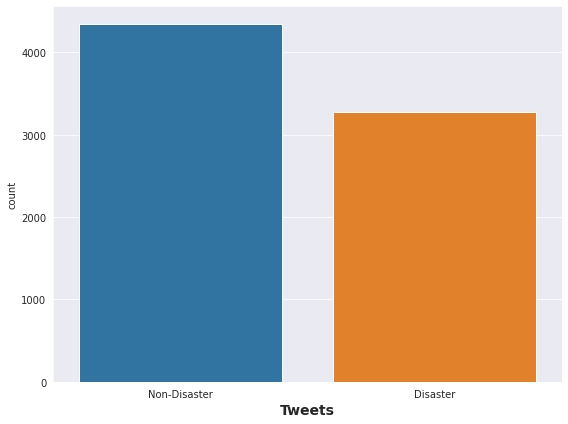

In [9]:
print("Train dataset shape : ",df_train.shape)
print("Test dataset shape : ",df_test.shape)

disaster_tweets = df_train[df_train.target ==1]['text']
non_disaster_tweets = df_train[df_train.target ==1]['text']

#distribution reviews
sns.set_style("darkgrid")
plt.figure(num=10, figsize=(8, 6))
sns.countplot(x=df_train.target)
plt.xlabel('Tweets', fontweight='bold', fontsize= 14)
plt.xticks(ticks = [0,1], labels = ["Non-Disaster", "Disaster"])
plt.tight_layout()

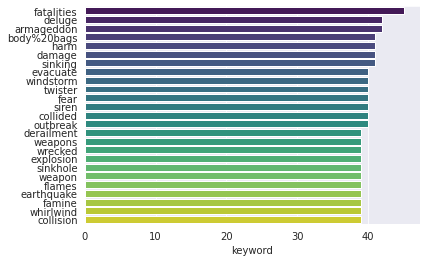

In [10]:
df_train['keyword'].value_counts()
sns.barplot(y=df_train['keyword'].value_counts()[:25].index,x=df_train['keyword'].value_counts()[:25], orient='horizontal', palette='viridis')

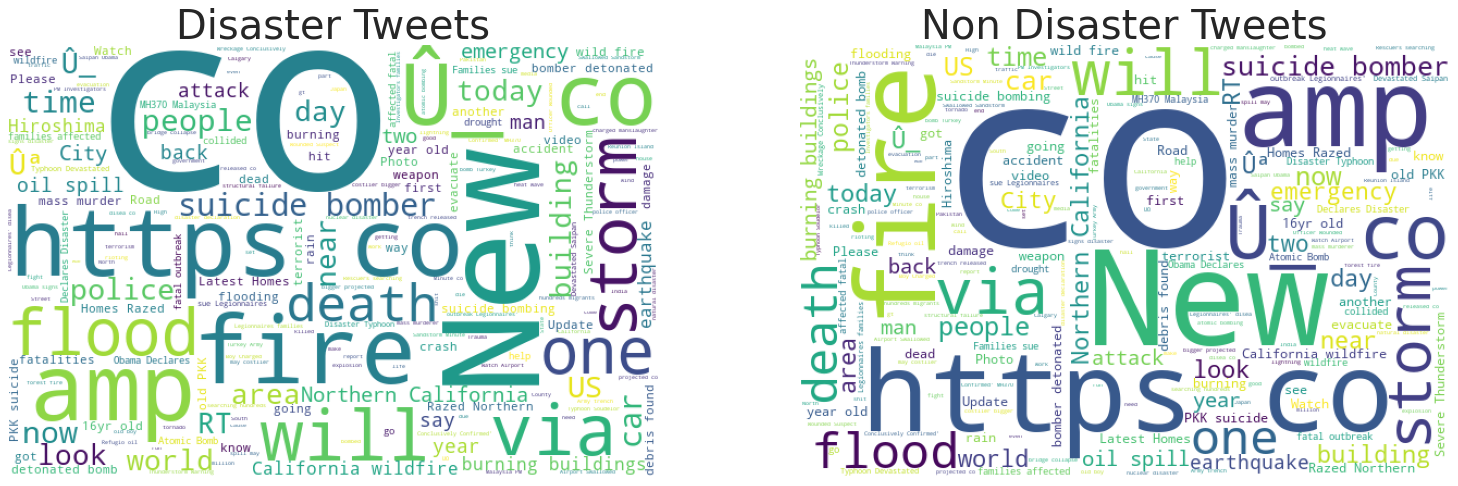

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[26, 8])
wordcloud1 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(disaster_tweets))
ax1.imshow(wordcloud1)
ax1.axis('off')
ax1.set_title('Disaster Tweets',fontsize=40);

wordcloud2 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(non_disaster_tweets))
ax2.imshow(wordcloud2)
ax2.axis('off')
ax2.set_title('Non Disaster Tweets',fontsize=40);



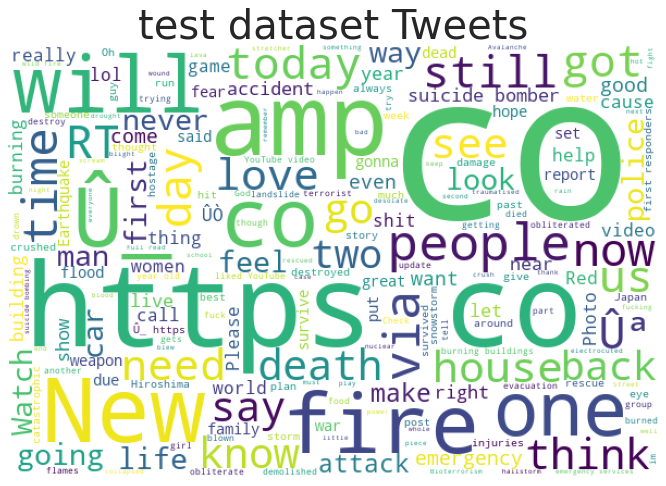

In [14]:
fig, (ax3) = plt.subplots(1, 1, figsize=[26, 8])
wordcloud3 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(df_test.text))
ax3.imshow(wordcloud3)
ax3.axis('off')
ax3.set_title('test dataset Tweets',fontsize=40);

# Create Model in _**R**_

In [2]:
# Activando R magic 
%load_ext rpy2.ipython

In [3]:
%%R 
if(!require(tidyverse)) install.packages('tidyverse')
if(!require(text2vec)) install.packages('text2vec')
if(!require(glmnet)) install.packages('glmnet')
if(!require(MLmetrics)) install.packages('MLmetrics')
if(!require(tm)) install.packages('tm')
if(!require(SnowballC)) install.packages('SnowballC')
if(!require(caTools)) install.packages('caTools')
if(!require(caret)) install.packages('caret')
if(!require(rpart)) install.packages('rpart')
if(!require(rpart.plot)) install.packages('rpart.plot')
if(!require(e1071)) install.packages('e1071')

library(e1071)
library(tidyverse)
library(text2vec) # text vectorization
library(glmnet) # building model cv.gmlnet()
library(MLmetrics) # F1_Score()
library(tm)
library(SnowballC)
library(caTools)
library(rpart)
library(rpart.plot)

R[write to console]: Loading required package: tidyverse

R[write to console]: ── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

R[write to console]: ✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.1.1     ✔ dplyr   1.0.5
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

R[write to console]: ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

R[write to console]: Loading required package: text2vec

R[write to console]: Loading required package: glmnet

R[write to console]: Loading required package: Matrix

R[write to console]: 
Attaching package: ‘Matrix’


R[write to console]: The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


R[write to console]: Loaded glmnet 4.1-1

R[write to console]: Loading required package: MLmetrics

R[write to console]: 
Attaching package: ‘MLmetrics’


R[write to cons

In [4]:
%%R 
tweets_test = read.csv('https://raw.githubusercontent.com/capajaro/Data_Mining_Project-/main/test.csv', stringsAsFactors=FALSE)
tweets = read.csv("https://raw.githubusercontent.com/capajaro/Data_Mining_Project-/main/train.csv", stringsAsFactors=FALSE)
submission = read.csv('https://raw.githubusercontent.com/capajaro/Data_Mining_Project-/main/sample_submission.csv', stringsAsFactors=FALSE)


## Preprocessing for modeling

In [5]:
%%R 
#Preprocessing
corpus = Corpus(VectorSource(tweets$text))
corpus = tm_map(corpus, tolower)
corpus = tm_map(corpus, removePunctuation)
corpus = tm_map(corpus, removeWords, c(stopwords("english")))
corpus = tm_map(corpus, stemDocument)
Sparc = 0.995
frequencies = DocumentTermMatrix(corpus)
sparse = removeSparseTerms(frequencies, Sparc) 
tweetsSparse = as.data.frame(as.matrix(sparse))

colnames(tweetsSparse)= make.names(colnames(tweetsSparse))

target = as.factor(tweets$target)
id = tweets$id
tweetsSparse_Cluster = cbind(id,target,tweetsSparse)
tweetsSparse$target = as.factor(tweets$target)


## Splitting Data in 5 Clusters

R[write to console]: The "ward" method has been renamed to "ward.D"; note new "ward.D2"



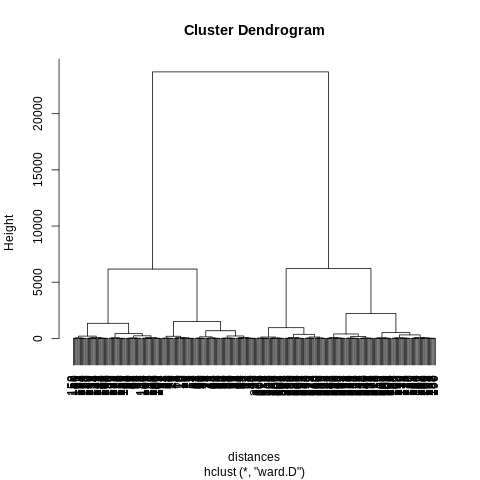

In [6]:
%%R
#Compute distances
distances = dist(tweetsSparse_Cluster[3:ncol(tweetsSparse_Cluster),], method = "euclidean")

#Hierarchical clustering
clusterMovies = hclust(distances, method = "ward") 

#Assign points to clusters
clusterGroups = cutree(clusterMovies, k = 5)

#Create a new data set with each Cluster
cluster1 = subset(tweetsSparse_Cluster, clusterGroups==1)
cluster2 = subset(tweetsSparse_Cluster, clusterGroups==2)
cluster3 = subset(tweetsSparse_Cluster, clusterGroups==3)
cluster4 = subset(tweetsSparse_Cluster, clusterGroups==4)
cluster5 = subset(tweetsSparse_Cluster, clusterGroups==5)

cluster1_Reg = cluster1[,2:ncol(cluster1)]
cluster2_Reg = cluster2[,2:ncol(cluster2)]
cluster3_Reg = cluster3[,2:ncol(cluster3)]
cluster4_Reg = cluster4[,2:ncol(cluster4)]
cluster5_Reg = cluster5[,2:ncol(cluster5)]

#Plot the dendrogram
plot(clusterMovies)


## Runing Model

In [22]:
%%R

#Create a new model with each Cluster
SVM_Cl1 <- svm(formula = target ~., data = cluster1_Reg, kernel = "linear",
                  cost = 10, scale = FALSE)

SVM_Cl2 <- svm(formula = target ~., data = cluster2_Reg, kernel = "linear",
                  cost = 10, scale = FALSE)

SVM_Cl3 <- svm(formula = target ~., data = cluster3_Reg, kernel = "linear",
                  cost = 10, scale = FALSE)

SVM_Cl4 <- svm(formula = target ~., data = cluster4_Reg, kernel = "linear",
                  cost = 10, scale = FALSE)

SVM_Cl5 <- svm(formula = target ~., data = cluster5_Reg, kernel = "linear",
                  cost = 10, scale = FALSE)

## Calculating Centroid for each Cluster

In [23]:
%%R

#Calculate centroids of each cluster
centroid_1 <- colMeans(cluster1_Reg[,2:ncol(cluster1_Reg)])
centroid_2 <- colMeans(cluster2_Reg[,2:ncol(cluster2_Reg)])
centroid_3 <- colMeans(cluster3_Reg[,2:ncol(cluster3_Reg)])
centroid_4 <- colMeans(cluster4_Reg[,2:ncol(cluster4_Reg)])
centroid_5 <- colMeans(cluster5_Reg[,2:ncol(cluster5_Reg)])

## Using model on test

In [24]:
%%R
#Preprocessing
corpus_test = Corpus(VectorSource(tweets_test$text))
corpus_test = tm_map(corpus_test, tolower)
corpus_test = tm_map(corpus_test, removePunctuation)
corpus_test = tm_map(corpus_test, removeWords, c(stopwords("english")))
corpus_test = tm_map(corpus_test, stemDocument)

frequencies_test = DocumentTermMatrix(corpus_test)

tweetsSparse_test = as.data.frame(as.matrix(frequencies_test))

colnames(tweetsSparse_test)= make.names(colnames(tweetsSparse_test))

tweetsSparse_test_dist = tweetsSparse_test[colnames(cluster1_Reg[,2:ncol(cluster1_Reg)])]


In [ ]:
%%R
Mod_preds

In [ ]:
%%R
cluster_tag = c(1,2,3,4,5)
print('Inicio Asignacion Cluster')
for (irow in 1:nrow(tweetsSparse_test)){
  row.int = tweetsSparse_test_dist[irow,]
  d1 = sum((row.int - centroid_1)^2); 
  d2 = sum((row.int - centroid_2)^2); 
  d3 = sum((row.int - centroid_3)^2); 
  d4 = sum((row.int - centroid_4)^2); 
  d5 = sum((row.int - centroid_5)^2); 
  dists = c(d1,d2,d3,d4,d5)

  if (min(dists) == d1 ){ Mod_val = predict(SVM_Cl1,newdata=row.int)} 
  else if (min(dists) == d2 ){ Mod_val = predict(SVM_Cl2,newdata=row.int)}
  else if (min(dists) == d3 ){ Mod_val = predict(SVM_Cl3,newdata=row.int)}
  else if (min(dists) == d4 ){ Mod_val = predict(SVM_Cl4,newdata=row.int)}
  if (min(dists) == d5 ){ Mod_val = predict(SVM_Cl5,newdata=row.int)}
  
  if (irow == 1){
  
  Mod_preds = Mod_val
  } else {
    Mod_preds = cbind(Mod_preds,Mod_val)}
}
print('Fin Asignacion Cluster')
  

[1] "Inicio Asignacion Cluster"
[1] 1
[1] 2
[1] 3
[1] 4
[1] 5
[1] 6
[1] 7
[1] 8
[1] 9
[1] 10
[1] 11
[1] 12
[1] 13
[1] 14
[1] 15
[1] 16
[1] 17
[1] 18
[1] 19
[1] 20
[1] 21
[1] 22
[1] 23
[1] 24
[1] 25
[1] 26
[1] 27
[1] 28
[1] 29
[1] 30
[1] 31
[1] 32
[1] 33
[1] 34
[1] 35
[1] 36
[1] 37
[1] 38
[1] 39
[1] 40
[1] 41
[1] 42
[1] 43
[1] 44
[1] 45
[1] 46
[1] 47
[1] 48
[1] 49
[1] 50
[1] 51
[1] 52
[1] 53
[1] 54
[1] 55
[1] 56
[1] 57
[1] 58
[1] 59
[1] 60
[1] 61
[1] 62
[1] 63
[1] 64
[1] 65
[1] 66
[1] 67
[1] 68
[1] 69
[1] 70
[1] 71
[1] 72
[1] 73
[1] 74
[1] 75
[1] 76
[1] 77
[1] 78
[1] 79
[1] 80
[1] 81
[1] 82
[1] 83
[1] 84
[1] 85
[1] 86
[1] 87
[1] 88
[1] 89
[1] 90
[1] 91
[1] 92
[1] 93
[1] 94
[1] 95
[1] 96
[1] 97
[1] 98
[1] 99
[1] 100
[1] 101
[1] 102
[1] 103
[1] 104
[1] 105
[1] 106
[1] 107
[1] 108
[1] 109
[1] 110
[1] 111
[1] 112
[1] 113
[1] 114
[1] 115
[1] 116
[1] 117
[1] 118
[1] 119
[1] 120
[1] 121
[1] 122
[1] 123
[1] 124
[1] 125
[1] 126
[1] 127
[1] 128
[1] 129
[1] 130
[1] 131
[1] 132
[1] 133
[1] 134
[1] 

From cffi callback <function _processevents at 0x7fb1966688c0>:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/rpy2/rinterface_lib/callbacks.py", line 274, in _processevents
    @ffi_proxy.callback(ffi_proxy._processevents_def,
KeyboardInterrupt


[1] 189
[1] 190
[1] 191
[1] 192
[1] 193
[1] 194
[1] 195
[1] 196
[1] 197
[1] 198
[1] 199
[1] 200
[1] 201
[1] 202
[1] 203
[1] 204
[1] 205
[1] 206
[1] 207
[1] 208
[1] 209
[1] 210
[1] 211
[1] 212
[1] 213
[1] 214
[1] 215
[1] 216
[1] 217
[1] 218
[1] 219
[1] 220
[1] 221
[1] 222
[1] 223
[1] 224
[1] 225
[1] 226
[1] 227
[1] 228
[1] 229
[1] 230
[1] 231
[1] 232
[1] 233
[1] 234
[1] 235


## Saving File

In [12]:
%%R
# SAVE SUBMISSION FILE

Output = cbind(tweets_test$id, as.data.frame(t(Mod_preds - 1)))
colnames(Output) = c("id",	"target")
write.csv(Output, 'Mejor_Modelo_Cluster.csv', row.names = FALSE)